<a href="https://colab.research.google.com/github/nickwan/non_qb_cpoe/blob/master/non_qb_cpoe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-QB CPOE folks 

# Load in

In [1]:
!apt install subversion --quiet
!pip install adjustText --quiet
!pip install shap --quiet
!pip install scikit-garden --quiet

Reading package lists...
Building dependency tree...
Reading state information...
subversion is already the newest version (1.9.7-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [2]:
import time
from joblib import dump, load
import random
import requests
import json
import datetime
import os
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.model_selection import KFold 

from scipy.stats import pearsonr

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data_dir = '/content/drive/My Drive/nflfastR-data'
data_files = [f'{data_dir}/data/{x}' for x in os.listdir(f"""{data_dir}/data""") if x.endswith('.csv.gz')]
df = pd.DataFrame()
for fn in reversed(data_files):
  _df = pd.read_csv(fn, compression='gzip')
  df = df.append(_df, ignore_index=True)
df.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (42,167,168,169,170,179,180,183,184,189,190,191,192,195,196,204,205,206,232,233,234,239,241,242) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,204,205,206,227,228,232,233,234,239,241,242) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34,42,167,168,169,170,175,176,179,180,183,184,189,190,191,192,193,194,197,198,199,200,208,210,212,227,228,232,233,234,239,241,242,250,251) have mixed types.Specify dtype option on import or set low_memory=False.
  in

(943096, 306)

# Data describe 

## Get QB CPOE and make a really basic adjustment factor per QB-Season  
literally just the average CPOE per season, divided in half. We're going to assume half of the CPOE belongs to the QB and the other half belongs to the receiver (that is 100% not the case, but it's the naive model that we will work off of for now on this actually-for-free stream on twitch dot tv LUL KKool) 

In [4]:
df.loc[df['pass']==1,['cp','cpoe','season','passer', 'receiver',
       'pass', 'rush', 'name', 'first_down', 'play', 'passer_id',
       'receiver_id']].sample(10)

,cp,cpoe,season,passer,receiver,pass,rush,name,first_down,play,passer_id,receiver_id
312086,NaN,NaN,2011,M.Moore,NaN,1,0,M.Moore,0.0,1,00-0025708,NaN
407803,0.534727,46.527285,2019,R.Finley,T.Boyd,1,0,R.Finley,0.0,1,00-0035652,00-0033009
191451,0.785936,21.406384,2014,M.Stafford,J.Bell,1,0,M.Stafford,0.0,1,00-0026498,00-0027218
732994,NaN,NaN,2002,S.Matthews,D.Thompson,1,0,S.Matthews,0.0,1,00-0010560,00-0016373
149418,0.751312,24.868777,2008,D.McNabb,H.Baskett,1,0,D.McNabb,0.0,1,00-0011022,00-0024013
483465,0.669319,33.068087,2010,R.Fitzpatrick,L.Evans,1,0,R.Fitzpatrick,1.0,1,00-0023682,00-0022910
93509,0.409562,59.043784,2016,K.Cousins,P.Garcon,1,0,K.Cousins,1.0,1,00-0029604,00-0026345
704823,0.831800,16.820028,2012,A.Dalton,B.Green-Ellis,1,0,A.Dalton,0.0,1,00-0027973,00-0025860
407634,0.783258,21.674171,2019,D.Jones,K.Smith,1,0,D.Jones,0.0,1,00-0035710,00-0034988
715133,NaN,NaN,2002,R.Peete,S.Smith,1,0,R.Peete,0.0,1,00-0012732,00-0020337


In [5]:
id2name = (df
           .loc[:,['passer', 'passer_id']]
           .drop_duplicates()
           .dropna()
           .rename(columns={'passer':'name','passer_id':'id'}))
id2name = (id2name
           .append(df
                   .loc[:,['receiver','receiver_id']]
                   .drop_duplicates()
                   .dropna()
                   .rename(columns={'receiver':'name','receiver_id':'id'}))
           .drop_duplicates()
           .reset_index(drop=True))
id2name.sample(5)

,name,id
1951,A.Robinson,00-0029281
1947,B.Sankey,00-0031413
2900,R.Edwards,00-0004774
1794,G.Holt,00-0024174
1291,D.Lewis,00-0028087


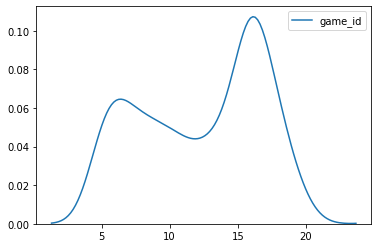

In [6]:
_df = df.loc[:,['game_id','season','passer_id']].drop_duplicates().groupby(['season','passer_id'],as_index=False).count()
sns.kdeplot(_df.loc[_df['game_id']>4,'game_id'])
_df.loc[_df['game_id']>4,'game_id'].describe()
game_filter = _df.loc[_df['game_id']>4,['season','passer_id']].drop_duplicates()

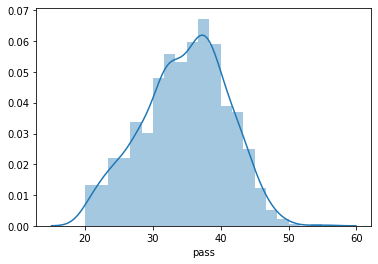

In [7]:
_df = df.loc[:,['game_id','season','passer_id','pass']].groupby(['season','game_id','passer_id'],as_index=False).sum()
_df = _df.groupby(['season','passer_id'],as_index=False).mean()
sns.distplot(_df.loc[_df['pass']>=20,'pass'])
plt.show()
_df.loc[_df['pass']>=20,'pass'].describe()
qb_filter = _df.loc[_df['pass']>=20,['season','passer_id']].drop_duplicates()

count    575.000000
mean     406.933913
std      171.447544
min       95.000000
25%      250.000000
50%      434.000000
75%      551.500000
max      782.000000
Name: pass, dtype: float64

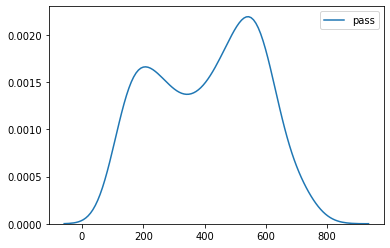

In [8]:
_df = (df
                 .dropna(subset=['cp','cpoe'])
                 .loc[df['pass']==1,
                      ['pass','season','passer_id']]
                 .groupby(['season','passer_id'],as_index=False).sum())
_df = _df.merge(qb_filter).merge(game_filter)
sns.kdeplot(_df.loc[:,'pass'])
_df['pass'].describe()

In [9]:
qb_season_avg = (df
                 .dropna(subset=['cp','cpoe'])
                 .loc[df['pass']==1,
                      ['cp','cpoe','season','passer_id']]
                 .groupby(['season','passer_id'],
                          as_index=False)
                 .mean())
qb_season_avg = qb_season_avg.merge(qb_filter).merge(game_filter)
qb_season_avg = qb_season_avg.rename(columns={'cp':'qb_cp','cpoe':'qb_cpoe'})
qb_season_avg = id2name.rename(columns={'id':'passer_id','name':'passer_name'}).merge(qb_season_avg)
qb_season_avg['qb_cpoe_adj'] = qb_season_avg['qb_cpoe'].div(2)
qb_season_avg.head()

,passer_name,passer_id,season,qb_cp,qb_cpoe,qb_cpoe_adj
0,J.Flacco,00-0026158,2008,0.602810,-2.396726,-1.198363
1,J.Flacco,00-0026158,2009,0.613057,1.264102,0.632051
2,J.Flacco,00-0026158,2010,0.612544,1.494288,0.747144
3,J.Flacco,00-0026158,2011,0.602816,-2.474296,-1.237148
4,J.Flacco,00-0026158,2012,0.595710,0.061994,0.030997


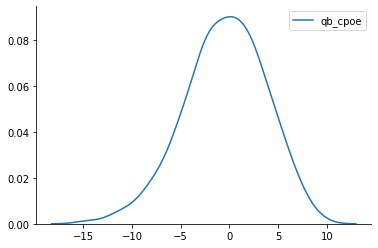

count    580.000000
mean      -0.467590
std        4.172328
min      -14.631832
25%       -3.051286
50%       -0.194697
75%        2.469484
max        9.349036
Name: qb_cpoe, dtype: float64

In [10]:
sns.kdeplot(qb_season_avg['qb_cpoe'])
sns.despine()
plt.show()
qb_season_avg['qb_cpoe'].describe()

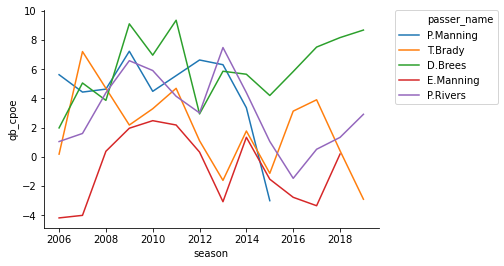

In [11]:
df_plt = qb_season_avg.loc[qb_season_avg['passer_id'].isin(['00-0020531','00-0010346','00-0022803','00-0022942','00-0019596'])] 
sns.lineplot('season','qb_cpoe',hue='passer_name',data=df_plt) 
sns.despine() 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show() 

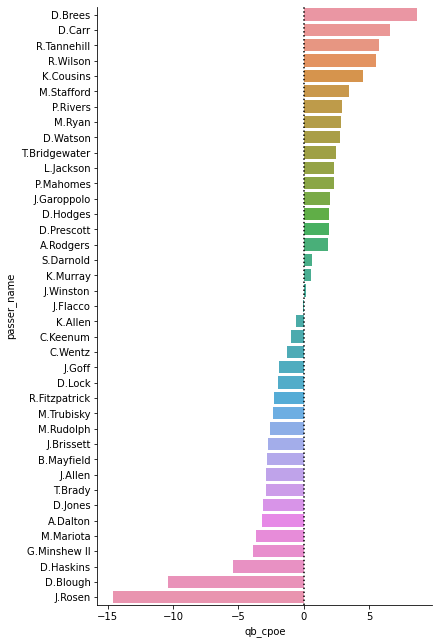

In [12]:
df_plt = qb_season_avg.loc[qb_season_avg['season']==2019].sort_values('qb_cpoe',ascending=False)
fig = sns.barplot('qb_cpoe','passer_name',data=df_plt,orient='h')
plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0],11)
sns.despine()
plt.axvline(0,c='k',ls=':')
plt.show()

## Join qb CPOE avgs back and do the WR side 
yeet 

In [0]:
df = df.merge(qb_season_avg.drop('passer_name',axis=1),how='left')

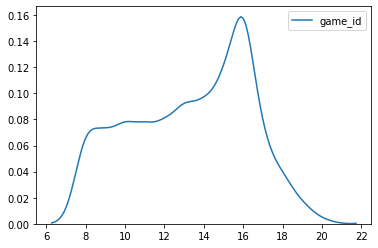

In [14]:
_df = df.loc[:,['game_id','season','receiver_id']].drop_duplicates().groupby(['season','receiver_id'],as_index=False).count()
sns.kdeplot(_df.loc[_df['game_id']>7,'game_id'])
_df.loc[_df['game_id']>7,'game_id'].describe()
game_filter = _df.loc[_df['game_id']>7,['season','receiver_id']].drop_duplicates()

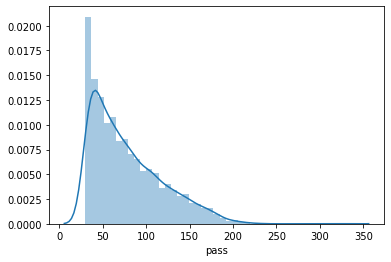

In [15]:
_df = df.loc[:,['season','receiver_id','pass']].groupby(['season','receiver_id'],as_index=False).sum()
_df = _df.groupby(['season','receiver_id'],as_index=False).mean()
sns.distplot(_df.loc[_df['pass']>=30,'pass'])
plt.show()
_df.loc[_df['pass']>=30,'pass'].describe()
wr_filter = _df.loc[_df['pass']>=30,['season','receiver_id']].drop_duplicates()

In [16]:
wr_cpoe_feats = ['season','passer', 'receiver','passer_id',
       'receiver_id','cp','cpoe','qb_cp', 'qb_cpoe',
       'qb_cpoe_adj']
df_wr = df.loc[df['pass']==1,wr_cpoe_feats].merge(wr_filter).merge(game_filter)
df_wr['cpoe_neutral'] = df_wr['cpoe'].sub(df_wr['qb_cpoe_adj'])
df_wr.shape

(315804, 11)

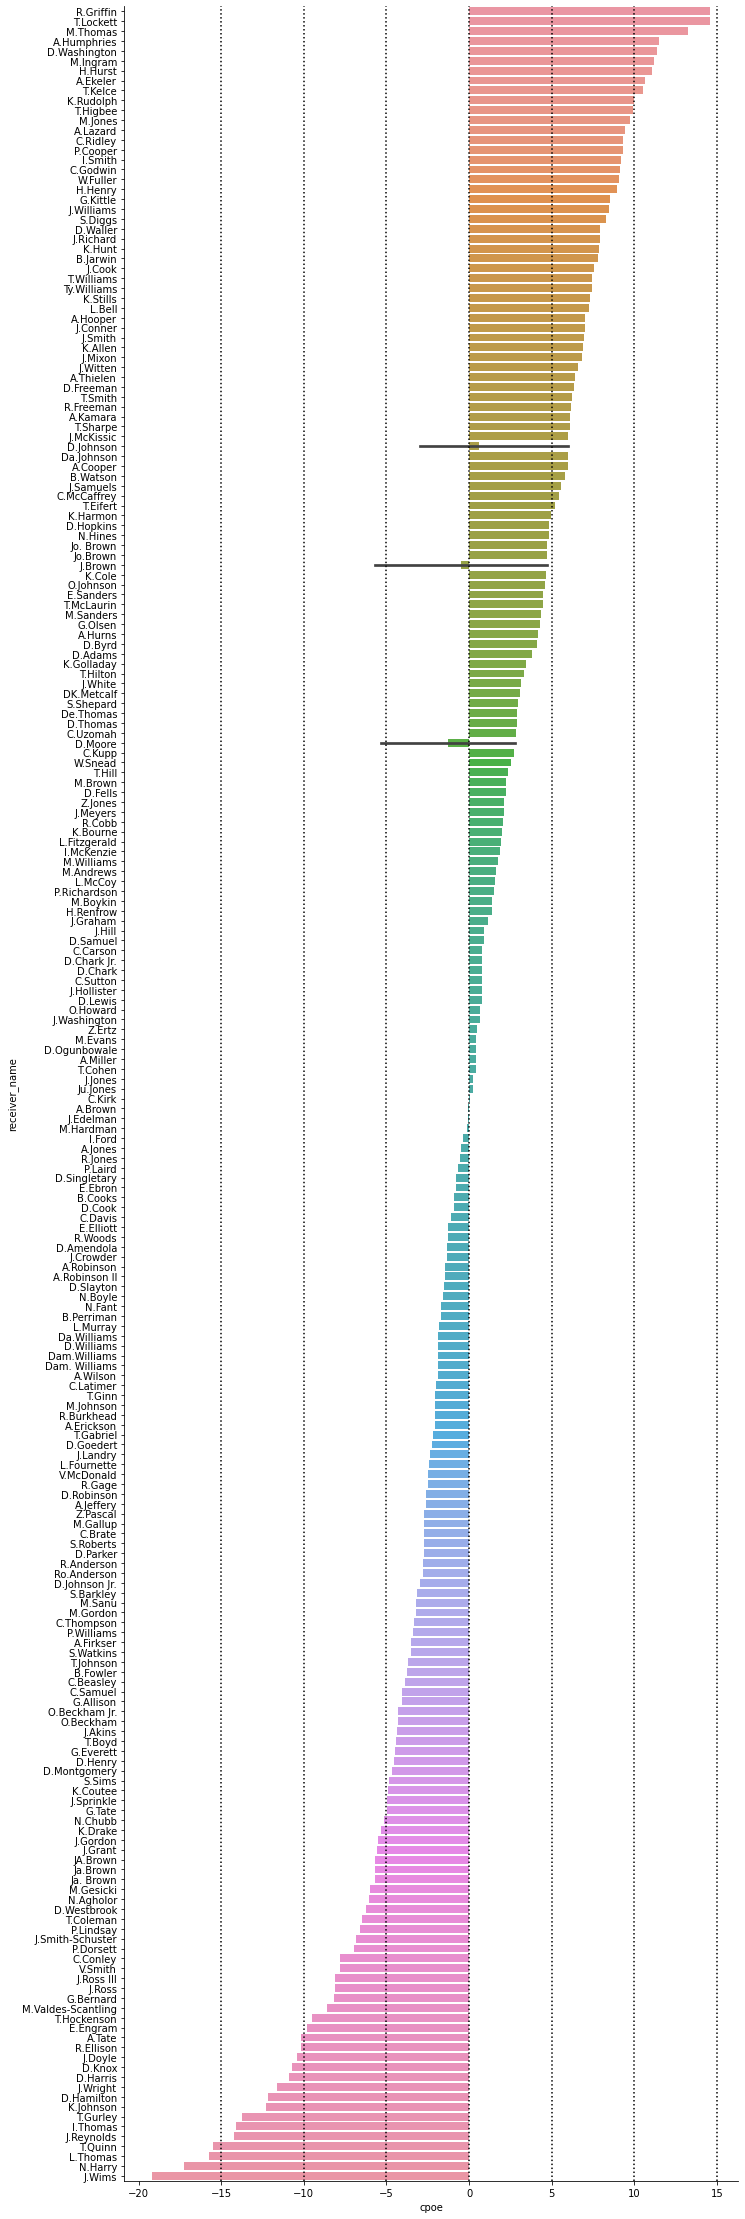

In [17]:
df_plt = (df_wr
          .dropna()
          .loc[:,['season','receiver_id','cp','cpoe']]
          .groupby(['season','receiver_id'],as_index=False)
          .mean())
df_plt = df_plt.merge(id2name.rename(columns={'id':'receiver_id', 'name':'receiver_name'}))
df_plt = df_plt.loc[df_plt['season']==2019].sort_values('cpoe',ascending=False)
fig = sns.barplot('cpoe','receiver_name',data=df_plt,orient='h')
plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0]+5,40)
sns.despine()
for v in np.arange(-15,16,5):
  plt.axvline(v,c='k',ls=':')
plt.show()

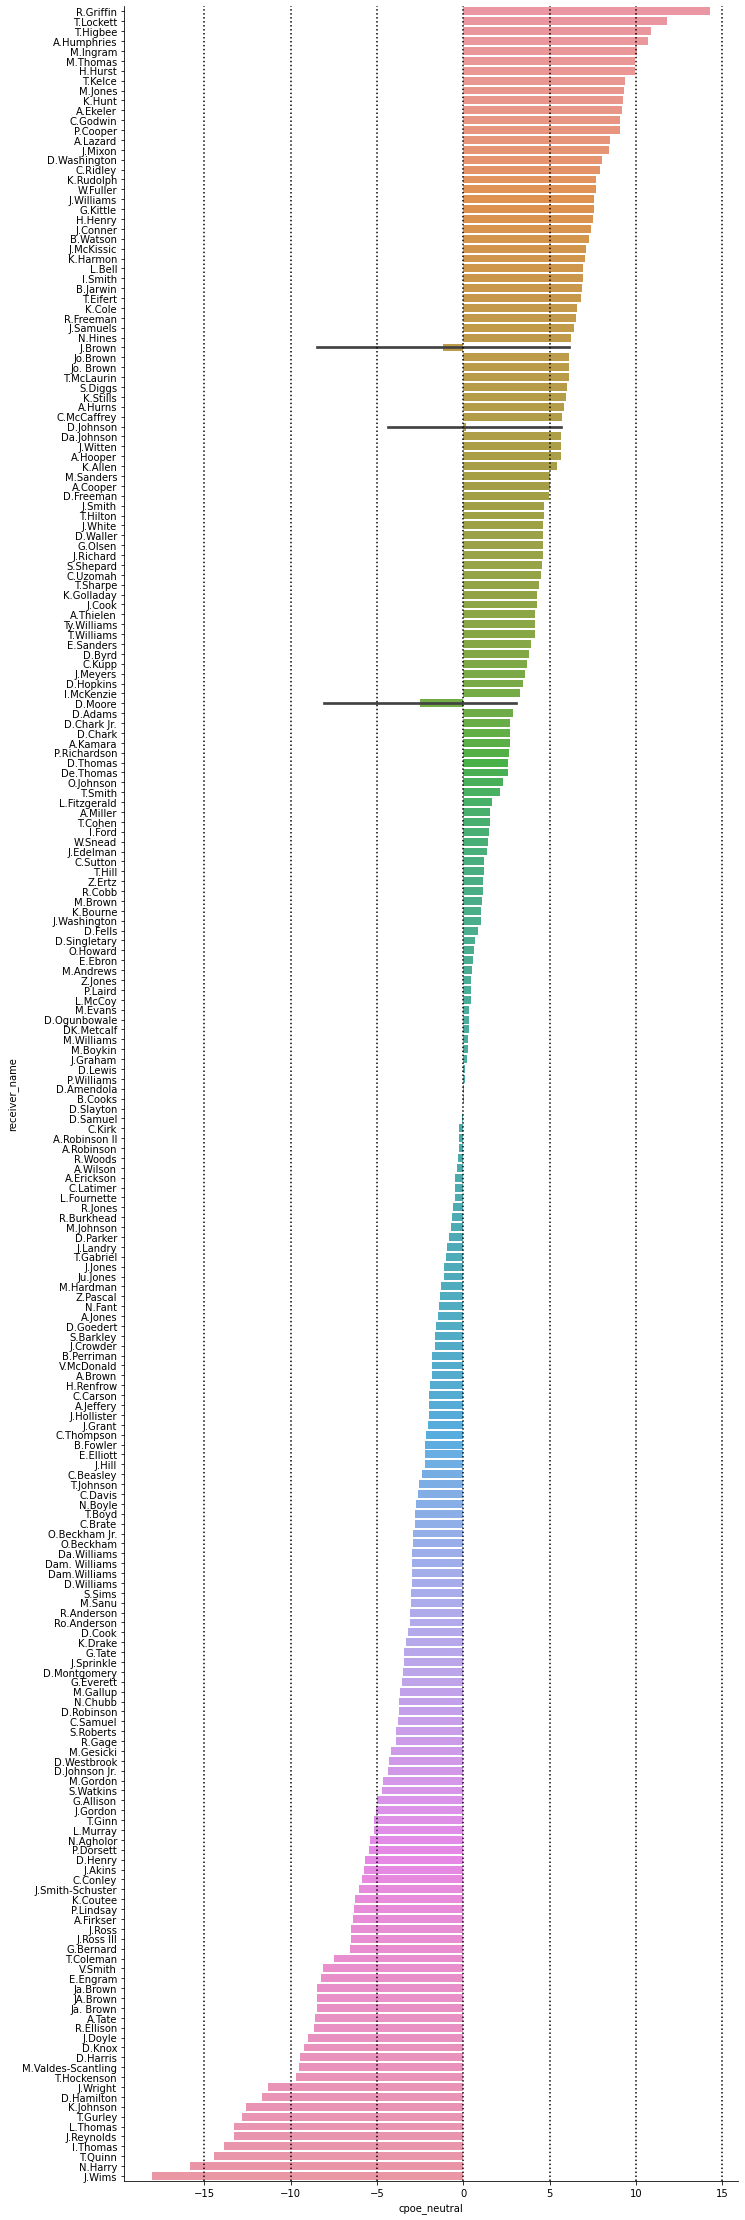

In [18]:
df_plt = (df_wr
          .dropna()
          .loc[:,['season','receiver_id','cp','cpoe_neutral']]
          .groupby(['season','receiver_id'],as_index=False)
          .mean())
df_plt = df_plt.merge(id2name.rename(columns={'id':'receiver_id', 'name':'receiver_name'}))
df_plt = df_plt.loc[df_plt['season']==2019].sort_values('cpoe_neutral',ascending=False)
fig = sns.barplot('cpoe_neutral','receiver_name',data=df_plt,orient='h')
plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0]+5,40)
sns.despine()
for v in np.arange(-15,16,5):
  plt.axvline(v,c='k',ls=':')
plt.show()

### What makes more sense:  
1. $$\text{WR CPOE} = \frac{\text{CPOE}_{raw} - \text{CPOE}_{adj}}{2}$$  

2. $$\text{WR CPOE} = \frac{\text{CPOE}_{raw}}{2}  - \text{CPOE}_{adj}$$  

Where  
$$\text{CPOE}_{adj} = \frac{\bar{\text{CPOE}_{qb}}}{2}$$  

I think #2 is better because it matches the logic before -- where we're trying to attribute CPOE to a player, and we are under the assumption that half goes to the receiver and the other half goes to the passer -- and also the remainder CPOE should be "everything else" (o line, defense, play type, etc). So technically:  

$$ CPOE_{WR} + CPOE_{QB} = CPOE + \text{unaccounted interactions} + \text{error} $$

Update: I tried the $raw/2$ approach and it sucked. So maybe it would be better to neutralize the quarterback first and then get the CPOE avgs for receivers second -- since we'd have CPOE _technically_ without the context of the passer anymore. _Technically_... 

In [0]:
wr_cpoe_avg = df_wr.loc[:,['season','receiver_id','cpoe_neutral']].groupby(['season','receiver_id'],as_index=False).mean()
wr_cpoe_avg['wr_cpoe'] = wr_cpoe_avg['cpoe_neutral'].div(2)
wr_cpoe_avg = id2name.rename(columns={'id':'receiver_id'}).merge(wr_cpoe_avg).dropna()
df = df.merge(wr_cpoe_avg.drop(['name','cpoe_neutral'],axis=1), how='left')

In [20]:
df.loc[(df['pass']==1)&(df['receiver_id']=='00-0031588')&(df['season']==2015), ['cp','cpoe','qb_cpoe','wr_cpoe']].sample(10)

,cp,cpoe,qb_cpoe,wr_cpoe
927131,NaN,NaN,2.09845,1.458976
958864,0.526101,-52.610117,2.09845,1.458976
927072,0.607570,-60.756969,2.09845,1.458976
940563,0.847669,15.233113,2.09845,1.458976
946417,0.669580,33.042003,2.09845,1.458976
951814,0.655861,34.413927,2.09845,1.458976
927054,0.517425,48.257473,2.09845,1.458976
923130,0.368145,-36.814516,2.09845,1.458976
948165,0.840671,15.932928,2.09845,1.458976
934497,0.295941,-29.594083,2.09845,1.458976


In [0]:
batteries = df.loc[:,['season','posteam','passer','passer_id','receiver','receiver_id','qb_cpoe','wr_cpoe']].dropna().drop_duplicates()
batteries['battery_cpoe'] = batteries['qb_cpoe'].add(batteries['wr_cpoe'])
_x = df.loc[:,['season', 'passer_id','receiver_id','ep', 'epa', 'cp', 'cpoe']].groupby(['season', 'passer_id','receiver_id'],as_index=False).mean()
_y = df.loc[:,['season', 'passer_id','receiver_id','pass']].groupby(['season', 'passer_id','receiver_id'],as_index=False).sum()
_raw = _y.merge(_x)
batteries = batteries.merge(_raw)
batteries.shape

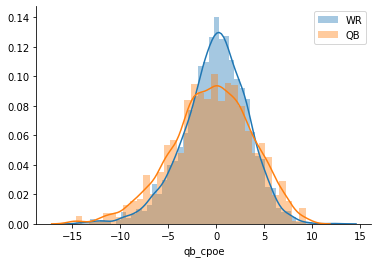

,qb_cpoe,wr_cpoe
count,3728.000000,3728.000000
mean,-0.481397,-0.117092
std,4.179181,3.376177
min,-14.631832,-14.212761
25%,-3.029404,-2.047274
50%,-0.284043,0.097215
75%,2.452466,2.181811
max,9.349036,12.629139


In [22]:
sns.distplot(batteries['wr_cpoe'],label='WR')
sns.distplot(batteries['qb_cpoe'],label='QB')
plt.legend()
sns.despine()
plt.show()
batteries.loc[:,['qb_cpoe','wr_cpoe']].describe()

In [30]:
batteries.sort_values('battery_cpoe',ascending=False).head(15)

,season,posteam,passer,passer_id,receiver,receiver_id,qb_cpoe,wr_cpoe,battery_cpoe,pass,ep,epa,cp,cpoe
3264,2009,NO,D.Brees,00-0020531,R.Meachem,00-0025414,9.101918,9.283429,18.385346,64,2.264015,0.802426,0.526886,23.117816
1337,2011,GB,A.Rodgers,00-0023459,R.Cobb,00-0028002,9.022586,8.616063,17.638649,35,1.720889,0.815835,0.626316,21.743419
1331,2011,NO,D.Brees,00-0020531,M.Colston,00-0024466,9.349036,7.770500,17.119536,130,1.866476,0.829315,0.565845,20.215517
755,2008,LAC,P.Rivers,00-0022942,M.Floyd,00-0022414,4.381365,11.699651,16.081016,39,2.049611,0.816737,0.473830,25.589985
1329,2011,GB,A.Rodgers,00-0023459,J.Nelson,00-0026176,9.022586,6.176036,15.198622,91,2.280203,0.895567,0.544010,16.863364
2237,2018,SEA,R.Wilson,00-0029263,T.Lockett,00-0032211,5.448078,9.571370,15.019448,84,1.695483,1.074206,0.583964,21.866779
2903,2007,PIT,B.Roethlisberger,00-0022924,H.Miller,00-0023465,7.071925,7.618297,14.690222,67,2.298131,0.725387,0.612274,18.772557
2182,2018,NO,D.Brees,00-0020531,M.Thomas,00-0032765,8.160225,6.493334,14.653559,179,2.231329,0.625103,0.662666,17.066780
189,2013,DEN,P.Manning,00-0010346,J.Tamme,00-0026267,6.303572,8.312793,14.616366,29,2.415792,0.579174,0.648380,19.777373
2185,2018,NO,D.Brees,00-0020531,B.Watson,00-0022943,8.160225,5.965194,14.125419,44,2.576273,0.596497,0.630593,16.010500


In [31]:
batteries.loc[(batteries['season']==2010)&(batteries['posteam']=='LAC')].sort_values('battery_cpoe',ascending=False)

,season,posteam,passer,passer_id,receiver,receiver_id,qb_cpoe,wr_cpoe,battery_cpoe,pass,ep,epa,cp,cpoe
2010,2010,LAC,P.Rivers,00-0022942,A.Gates,00-0021547,5.905078,7.575441,13.480519,68,2.314848,0.811703,0.588197,18.103421
2044,2010,LAC,P.Rivers,00-0022942,P.Crayton,00-0022766,5.905078,4.225393,10.130471,44,1.746269,0.880187,0.552633,11.403326
2011,2010,LAC,P.Rivers,00-0022942,D.Sproles,00-0023564,5.905078,1.251656,7.156734,77,1.694072,0.184864,0.742739,5.455851
2008,2010,LAC,P.Rivers,00-0022942,M.Floyd,00-0022414,5.905078,-1.458132,4.446945,80,2.164112,0.300089,0.480157,0.036274
2009,2010,LAC,P.Rivers,00-0022942,L.Naanee,00-0025559,5.905078,-4.832569,1.072508,49,2.279944,0.161327,0.567126,-6.712600


In [0]:
palette = sns.palettes.hls_palette(10)

In [0]:
def battery_plot(x,y,title,data,color='k'):
  _data = data.dropna(subset=[x,y]) 
  r2 = pearsonr(_data.loc[:,x],_data.loc[:,y])[0]**2 
  rmse = mean_squared_error(_data.loc[:,x],_data.loc[:,y])**0.5 
  f = sns.regplot(x,y,data=_data,color=color,line_kws={'color':'k'})
  # f.set_aspect('equal')
  sns.despine()
  plt.title(f'{title}\nR2: {round(r2,3)}\nRMSE: {round(rmse,3)}')
  plt.show()

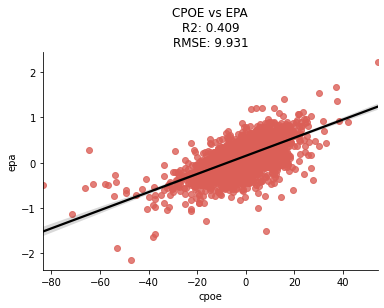

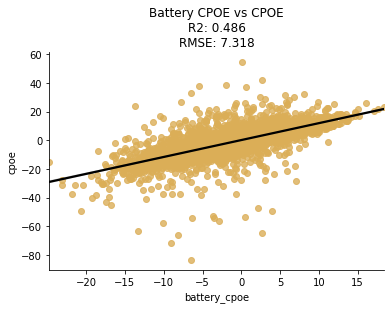

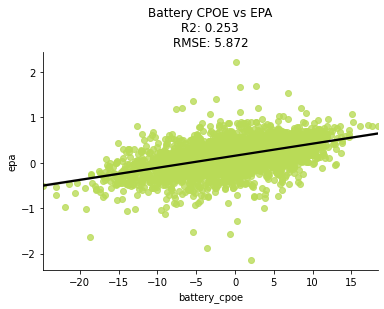

In [60]:
battery_plot('cpoe','epa','CPOE vs EPA',batteries,color=palette[0])
battery_plot('battery_cpoe','cpoe','Battery CPOE vs CPOE',batteries,color=palette[1])
battery_plot('battery_cpoe','epa','Battery CPOE vs EPA',batteries,color=palette[2])

In [0]:
bat_cols = ['season', 'posteam', 'passer','receiver','pass','battery_cpoe', 'cpoe', 'epa']
all_cols = ['season', 'posteam', 'passer','receiver','pass','qb_cpoe','wr_cpoe','battery_cpoe', 'cpoe', 'epa']
qb_cols = ['season', 'posteam', 'passer','pass','qb_cpoe','wr_cpoe','battery_cpoe', 'cpoe', 'epa']

In [68]:
batteries.loc[(batteries['season']==2019)&(batteries['posteam']=='KC'),bat_cols].sort_values('battery_cpoe',ascending=False).rename(columns={'pass':'attempts'})

,season,posteam,passer,receiver,attempts,battery_cpoe,cpoe,epa
1629,2019,KC,P.Mahomes,T.Kelce,154,6.976519,10.510281,0.606017
1627,2019,KC,P.Mahomes,T.Hill,97,2.886681,2.330603,0.429967
1636,2019,KC,P.Mahomes,L.McCoy,30,2.503774,1.564790,-0.074869
1637,2019,KC,P.Mahomes,M.Hardman,51,1.659196,-0.124365,0.740536
1630,2019,KC,P.Mahomes,Dam.Williams,236,0.795625,-1.851509,0.172676
1633,2019,KC,P.Mahomes,D.Robinson,60,0.431060,-2.580638,0.233550
1628,2019,KC,P.Mahomes,S.Watkins,97,-0.047501,-3.537760,0.429193


In [78]:
id2name.loc[id2name['name'].str.endswith('Fitzpatrick')]

,name,id
47,R.Fitzpatrick,00-0023682


In [77]:
pid = '00-0031325'
batteries.loc[(batteries['receiver_id']==pid),all_cols].sort_values('season',ascending=False).rename(columns={'pass':'attempts'})

,season,posteam,passer,receiver,attempts,qb_cpoe,wr_cpoe,battery_cpoe,cpoe,epa
1628,2019,KC,P.Mahomes,S.Watkins,97,2.295172,-2.342673,-0.047501,-3.537760,0.429193
2203,2018,KC,P.Mahomes,S.Watkins,80,2.625547,1.845300,4.470847,5.003374,0.636293
1149,2017,LA,J.Goff,S.Watkins,79,-0.974617,-0.122789,-1.097406,-0.732887,0.415643
311,2016,BUF,T.Taylor,S.Watkins,44,1.016186,0.299397,1.315584,1.106888,0.444270
3513,2015,BUF,T.Taylor,S.Watkins,99,2.981303,3.516912,6.498215,8.524476,0.543727
1000,2014,BUF,K.Orton,S.Watkins,100,-0.567236,-3.108058,-3.675294,-6.499734,0.114436


In [80]:
pid = '00-0023682'
batteries.loc[(batteries['passer_id']==pid),all_cols].groupby(['season', 'posteam', 'passer'],as_index=False).mean().sort_values('season',ascending=False).rename(columns={'pass':'attempts'})

,season,posteam,passer,attempts,qb_cpoe,wr_cpoe,battery_cpoe,cpoe,epa
11,2019,MIA,R.Fitzpatrick,50.777778,-2.270621,-0.156172,-2.426793,0.906982,0.177052
10,2018,TB,R.Fitzpatrick,34.125000,4.156416,0.414507,4.570923,2.297842,0.241902
9,2017,TB,R.Fitzpatrick,23.857143,-1.857361,1.215243,-0.642118,0.302387,0.159320
8,2016,NYJ,R.Fitzpatrick,65.500000,-5.781514,-1.132101,-6.913616,-4.345576,0.025290
7,2015,NYJ,R.Fitzpatrick,87.800000,-2.075857,0.401617,-1.674240,-0.234694,0.241476
6,2014,HOU,R.Fitzpatrick,58.400000,0.496988,-0.291064,0.205924,-0.333635,0.238432
5,2013,TEN,R.Fitzpatrick,74.666667,0.684797,-1.348828,-0.664031,-2.051301,0.195032
4,2012,BUF,R.Fitzpatrick,127.000000,-2.468825,-0.120102,-2.588927,-1.474616,0.130354
3,2011,BUF,R.Fitzpatrick,91.777778,1.003506,0.373321,1.376827,0.375884,0.029412
2,2010,BUF,R.Fitzpatrick,93.428571,-1.841228,-0.880560,-2.721788,-2.681734,0.075990
